ResNet

In [ ]:
import torch
import torch.nn as nn

def conv_block_1(in_dim, out_dim, act_fn):
    model = nn.Sequential(
        nn.Conv2d(in_dim, out_dim, kernel_size=1, stride=1),
        act_fn,
    )
    return model

def conv_block_1_stride_2(in_dim, out_dim, act_fn):
    model = nn.Sequential(
        nn.Conv2d(in_dim, out_dim, kernel_size=1, stride=2),
        act_fn,
    )
    return model

def conv_block_1_n(in_dim, out_dim):
    model = nn.Sequential(
        nn.Conv2d(in_dim, out_dim, kernel_size=1, stride=1),
    )
    return model

def conv_block_1_stride_2_n(in_dim, out_dim):
    model = nn.Sequential(
        nn.Conv2d(in_dim, out_dim, kernel_size=1, stride=2),
    )
    return model

def conv_block_3(in_dim, out_dim, act_fn):
    model = nn.Sequential(
        act_fn,
    )
    return model



class BottleNeck(nn.Module):
    def __init__(self,in_dim,mid_dim,out_dim,act_fn):
        super(BottleNeck,self).__init__()
        self.layer = nn.Sequential(
            conv_block_1(in_dim,mid_dim,act_fn),
            conv_block_3(mid_dim,mid_dim,act_fn),
            conv_block_1_n(mid_dim,out_dim),
        )
        self.downsample = nn.Conv2d(in_dim,out_dim,1,1)

    def forward(self,x):
        downsample = self.downsample(x)
        out = self.layer(x)
        out = out + downsample

        return out

class BottleNeck_no_down(nn.Module):
    def __init__(self,in_dim,mid_dim,out_dim,act_fn):
        super(BottleNeck_no_down,self).__init__()
        self.layer = nn.Sequential(
            conv_block_1(in_dim,mid_dim,act_fn),
            conv_block_3(mid_dim,mid_dim,act_fn),
            conv_block_1_n(mid_dim,out_dim),
        )
    
    def forward(self,x):
        out = self.layer(x)
        out = out + x

        return out

class BottleNeck_stride(nn.Module):
    def __init__(self,in_dim,mid_dim,out_dim,act_fn):
        super(BottleNeck_stride,self).__init__()
        self.layer = nn.Sequential(
            conv_block_1_stride_2(in_dim,mid_dim,act_fn),
            conv_block_3(mid_dim,mid_dim,act_fn),
            conv_block_1_n(mid_dim,out_dim),
        )  
        self.downsample = nn.Conv2d(in_dim,out_dim,1,2)

    def forward(self,x):
        downsample = self.downsample(x)
        out = self.layer(x)
        out = out + downsample

        return out



class ResNet(nn.Module):
    def __init__(self, base_dim, num_classes):
        super(ResNet, self).__init__()
        self.act_fn = nn.ReLU()
        self.layer_1 = nn.Sequential(
            nn.Conv2d(3,base_dim,7,2,3),
            nn.ReLU(), nn.MaxPool2d(3,2,1),
        )
        self.layer_2 = nn.Sequential(
            BottleNeck(base_dim,base_dim,base_dim*4,self.act_fn),
            BottleNeck_no_down(base_dim*4,base_dim,base_dim*4,self.act_fn),
            BottleNeck_stride(base_dim*4,base_dim,base_dim*4,self.act_fn),
        )
        self.layer_3 = nn.Sequential(
            BottleNeck(base_dim*4,base_dim*2,base_dim*8,self.act_fn),
            BottleNeck_no_down(base_dim*8,base_dim*2,base_dim*8,self.act_fn),
            BottleNeck_no_down(base_dim*8,base_dim*2,base_dim*8,self.act_fn),
            BottleNeck_stride(base_dim*8,base_dim*2,base_dim*8,self.act_fn),
        )
        self.layer_4 = nn.Sequential(
            BottleNeck(base_dim*8,base_dim*4,base_dim*16,self.act_fn),
            BottleNeck_no_down(base_dim*16,base_dim*4,base_dim*16,self.act_fn),
            BottleNeck_no_down(base_dim*16,base_dim*4,base_dim*16,self.act_fn),
            BottleNeck_no_down(base_dim*16,base_dim*4,base_dim*16,self.act_fn),
            BottleNeck_no_down(base_dim*16,base_dim*4,base_dim*16,self.act_fn),
            BottleNeck_stride(base_dim*16,base_dim*4,base_dim*16,self.act_fn),
        )
        self.layer_5 = nn.Sequential(
            BottleNeck(base_dim*16,base_dim*8,base_dim*32,nn.ReLU()),
            BottleNeck_no_down(base_dim*32,base_dim*8,base_dim*32,self.act_fn),
            BottleNeck(base_dim*32,base_dim*8,base_dim*32,self.act_fn),
        )
        self.avgpool = nn.AvgPool2d(7,1)
        self.fc_layer = nn.Linear(base_dim*128,num_classes)

    def forward(self, x):
        out = self.layer_1(x)
        out = self.layer_2(out)
        out = self.layer_3(out)
        out = self.layer_4(out)
        out = self.layer_5(out)
        out = self.avgpool(out)
        out = out.view(out.shape[0],-1)
        out = self.fc_layer(out)

        return out

Load Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

import torch
import numpy as np
import torchvision
import tqdm
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import cv2

from glob import glob
from PIL import Image

categories = ['brontosaurus', 'car_side', 'cougar_face', 'dalmatian', 'dollar_bill',
              'dragonfly', 'Faces', 'Faces_easy', 'flamingo', 'headphone',
              'lotus', 'menorah', 'nautilus', 'pagoda', 'soccer_ball',
              'stop_sign', 'sunflower', 'tick', 'windsor_chair', 'yin_yang']
train_img_len = 30
test_img_len = 5

class ImgDataset(Dataset):
    def __init__(self, method=None):
        self.root = '/content/gdrive/My Drive/'
        self.x_data = []
        self.y_data = []
        self.len = 0

        if method == 'train':
            self.root = self.root + 'dataset/train/'
            print('ImgDataset train')
            for idx, category in enumerate(categories):
                dir_path = self.root + category + '/'
                self.img_path = sorted(glob(dir_path + '*.jpg'))

                for i in tqdm.tqdm(range(len(self.img_path))):
                    img = Image.open(self.img_path[i]).convert("RGB")
                    img = img.resize((256, 256))
                    self.x_data.append(img)
                    self.y_data.append(idx)

                    self.len = self.len + 1

        elif method == 'test':
            print('ImgDataset test')
            self.root = self.root + 'dataset/test/'
            for idx, category in enumerate(categories):
                dir_path = self.root + category + '/'
                self.img_path = sorted(glob(dir_path + '*.jpg'))
            
                for i in tqdm.tqdm(range(len(self.img_path))):
                        img = Image.open(self.img_path[i]).convert("RGB")
                        img = img.resize((256, 256))
                        self.x_data.append(img)
                        self.y_data.append(idx)

                        self.len = self.len + 1
        

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        transform1 = torchvision.transforms.ToTensor()
        new_x_data = transform1(self.x_data[idx])

        return new_x_data, self.y_data[idx]

Mounted at /content/gdrive


Tester and Trainer

Finish build model.
ImgDataset train


  0%|          | 0/101 [00:00<?, ?it/s]

Training...
Epoch    0/100 Batch 0/12


  1%|          | 1/101 [00:04<08:10,  4.90s/it]

Epoch    1/100 Batch 0/12


  2%|▏         | 2/101 [00:08<07:34,  4.59s/it]

Epoch    2/100 Batch 0/12


  3%|▎         | 3/101 [00:13<07:33,  4.63s/it]

Epoch    3/100 Batch 0/12


  4%|▍         | 4/101 [00:17<07:07,  4.40s/it]

Epoch    4/100 Batch 0/12


  5%|▍         | 5/101 [00:22<07:11,  4.50s/it]

Epoch    5/100 Batch 0/12


  6%|▌         | 6/101 [00:25<06:50,  4.32s/it]

Epoch    6/100 Batch 0/12


  7%|▋         | 7/101 [00:30<06:56,  4.43s/it]

Epoch    7/100 Batch 0/12


  8%|▊         | 8/101 [00:34<06:37,  4.28s/it]

Epoch    8/100 Batch 0/12


  9%|▉         | 9/101 [00:39<06:44,  4.40s/it]

Epoch    9/100 Batch 0/12


 10%|▉         | 10/101 [00:43<06:27,  4.26s/it]

Epoch   10/100 Batch 0/12


 11%|█         | 11/101 [00:47<06:37,  4.42s/it]

Epoch   11/100 Batch 0/12


 12%|█▏        | 12/101 [00:51<06:20,  4.28s/it]

Epoch   12/100 Batch 0/12


 13%|█▎        | 13/101 [00:56<06:30,  4.44s/it]

Epoch   13/100 Batch 0/12


 14%|█▍        | 14/101 [01:00<06:14,  4.30s/it]

Epoch   14/100 Batch 0/12


 15%|█▍        | 15/101 [01:05<06:24,  4.47s/it]

Epoch   15/100 Batch 0/12


 16%|█▌        | 16/101 [01:09<06:07,  4.33s/it]

Epoch   16/100 Batch 0/12


 17%|█▋        | 17/101 [01:14<06:17,  4.49s/it]

Epoch   17/100 Batch 0/12


 18%|█▊        | 18/101 [01:18<06:00,  4.35s/it]

Epoch   18/100 Batch 0/12


 19%|█▉        | 19/101 [01:23<06:08,  4.50s/it]

Epoch   19/100 Batch 0/12


 20%|█▉        | 20/101 [01:27<05:53,  4.36s/it]

Epoch   20/100 Batch 0/12


 21%|██        | 21/101 [01:32<05:59,  4.50s/it]

Epoch   21/100 Batch 0/12


 22%|██▏       | 22/101 [01:36<05:44,  4.36s/it]

Epoch   22/100 Batch 0/12


 23%|██▎       | 23/101 [01:41<05:51,  4.51s/it]

Epoch   23/100 Batch 0/12


 24%|██▍       | 24/101 [01:45<05:36,  4.38s/it]

Epoch   24/100 Batch 0/12


 25%|██▍       | 25/101 [01:49<05:42,  4.51s/it]

Epoch   25/100 Batch 0/12


 26%|██▌       | 26/101 [01:54<05:28,  4.38s/it]

Epoch   26/100 Batch 0/12


 27%|██▋       | 27/101 [01:58<05:35,  4.53s/it]

Epoch   27/100 Batch 0/12


 28%|██▊       | 28/101 [02:03<05:21,  4.40s/it]

Epoch   28/100 Batch 0/12


 29%|██▊       | 29/101 [02:07<05:28,  4.56s/it]

Epoch   29/100 Batch 0/12


 30%|██▉       | 30/101 [02:12<05:14,  4.43s/it]

Epoch   30/100 Batch 0/12


 31%|███       | 31/101 [02:16<05:19,  4.56s/it]

Epoch   31/100 Batch 0/12


 32%|███▏      | 32/101 [02:21<05:05,  4.43s/it]

Epoch   32/100 Batch 0/12


 33%|███▎      | 33/101 [02:25<05:10,  4.57s/it]

Epoch   33/100 Batch 0/12


 34%|███▎      | 34/101 [02:30<04:57,  4.44s/it]

Epoch   34/100 Batch 0/12


 35%|███▍      | 35/101 [02:35<05:01,  4.57s/it]

Epoch   35/100 Batch 0/12


 36%|███▌      | 36/101 [02:39<04:49,  4.45s/it]

Epoch   36/100 Batch 0/12


 37%|███▋      | 37/101 [02:44<05:04,  4.75s/it]

Epoch   37/100 Batch 0/12


 38%|███▊      | 38/101 [02:48<04:48,  4.57s/it]

Epoch   38/100 Batch 0/12


 39%|███▊      | 39/101 [02:53<04:50,  4.68s/it]

Epoch   39/100 Batch 0/12


 40%|███▉      | 40/101 [02:57<04:35,  4.52s/it]

Epoch   40/100 Batch 0/12


 41%|████      | 41/101 [03:02<04:39,  4.66s/it]

Epoch   41/100 Batch 0/12


 42%|████▏     | 42/101 [03:07<04:26,  4.52s/it]

Epoch   42/100 Batch 0/12


 43%|████▎     | 43/101 [03:12<04:30,  4.67s/it]

Epoch   43/100 Batch 0/12


 44%|████▎     | 44/101 [03:16<04:17,  4.52s/it]

Epoch   44/100 Batch 0/12


 45%|████▍     | 45/101 [03:21<04:20,  4.65s/it]

Epoch   45/100 Batch 0/12


 46%|████▌     | 46/101 [03:25<04:08,  4.51s/it]

Epoch   46/100 Batch 0/12


 47%|████▋     | 47/101 [03:30<04:12,  4.68s/it]

Epoch   47/100 Batch 0/12


 48%|████▊     | 48/101 [03:34<04:00,  4.54s/it]

Epoch   48/100 Batch 0/12


 49%|████▊     | 49/101 [03:39<04:02,  4.66s/it]

Epoch   49/100 Batch 0/12


 50%|████▉     | 50/101 [03:43<03:50,  4.52s/it]

Epoch   50/100 Batch 0/12


 50%|█████     | 51/101 [03:48<03:53,  4.67s/it]

Epoch   51/100 Batch 0/12


 51%|█████▏    | 52/101 [03:53<03:42,  4.54s/it]

Epoch   52/100 Batch 0/12


 52%|█████▏    | 53/101 [03:58<03:46,  4.71s/it]

Epoch   53/100 Batch 0/12


 53%|█████▎    | 54/101 [04:02<03:34,  4.56s/it]

Epoch   54/100 Batch 0/12


 54%|█████▍    | 55/101 [04:07<03:36,  4.70s/it]

Epoch   55/100 Batch 0/12


 55%|█████▌    | 56/101 [04:11<03:25,  4.56s/it]

Epoch   56/100 Batch 0/12


 56%|█████▋    | 57/101 [04:16<03:27,  4.73s/it]

Epoch   57/100 Batch 0/12


 57%|█████▋    | 58/101 [04:20<03:17,  4.58s/it]

Epoch   58/100 Batch 0/12


 58%|█████▊    | 59/101 [04:26<03:17,  4.71s/it]

Epoch   59/100 Batch 0/12


 59%|█████▉    | 60/101 [04:30<03:07,  4.57s/it]

Epoch   60/100 Batch 0/12


 60%|██████    | 61/101 [04:35<03:09,  4.73s/it]

Epoch   61/100 Batch 0/12


 61%|██████▏   | 62/101 [04:39<02:58,  4.58s/it]

Epoch   62/100 Batch 0/12


 62%|██████▏   | 63/101 [04:44<03:00,  4.74s/it]

Epoch   63/100 Batch 0/12


 63%|██████▎   | 64/101 [04:48<02:50,  4.60s/it]

Epoch   64/100 Batch 0/12


 64%|██████▍   | 65/101 [04:54<02:50,  4.74s/it]

Epoch   65/100 Batch 0/12


 65%|██████▌   | 66/101 [04:58<02:40,  4.59s/it]

Epoch   66/100 Batch 0/12


 66%|██████▋   | 67/101 [05:03<02:41,  4.74s/it]

Epoch   67/100 Batch 0/12


 67%|██████▋   | 68/101 [05:07<02:31,  4.60s/it]

Epoch   68/100 Batch 0/12


 68%|██████▊   | 69/101 [05:12<02:31,  4.74s/it]

Epoch   69/100 Batch 0/12


 69%|██████▉   | 70/101 [05:16<02:22,  4.60s/it]

Epoch   70/100 Batch 0/12


 70%|███████   | 71/101 [05:22<02:22,  4.76s/it]

Epoch   71/100 Batch 0/12


 71%|███████▏  | 72/101 [05:26<02:13,  4.61s/it]

Epoch   72/100 Batch 0/12


 72%|███████▏  | 73/101 [05:31<02:13,  4.77s/it]

Epoch   73/100 Batch 0/12


 73%|███████▎  | 74/101 [05:35<02:04,  4.62s/it]

Epoch   74/100 Batch 0/12


 74%|███████▍  | 75/101 [05:40<02:03,  4.75s/it]

Epoch   75/100 Batch 0/12


 75%|███████▌  | 76/101 [05:45<01:55,  4.61s/it]

Epoch   76/100 Batch 0/12


 76%|███████▌  | 77/101 [05:50<01:53,  4.75s/it]

Epoch   77/100 Batch 0/12


 77%|███████▋  | 78/101 [05:54<01:45,  4.61s/it]

Epoch   78/100 Batch 0/12


 78%|███████▊  | 79/101 [05:59<01:44,  4.76s/it]

Epoch   79/100 Batch 0/12


 79%|███████▉  | 80/101 [06:03<01:36,  4.62s/it]

Epoch   80/100 Batch 0/12


 80%|████████  | 81/101 [06:08<01:34,  4.74s/it]

Epoch   81/100 Batch 0/12


 81%|████████  | 82/101 [06:13<01:27,  4.60s/it]

Epoch   82/100 Batch 0/12


 82%|████████▏ | 83/101 [06:18<01:25,  4.75s/it]

Epoch   83/100 Batch 0/12


 83%|████████▎ | 84/101 [06:22<01:18,  4.61s/it]

Epoch   84/100 Batch 0/12


 84%|████████▍ | 85/101 [06:27<01:16,  4.76s/it]

Epoch   85/100 Batch 0/12


 85%|████████▌ | 86/101 [06:31<01:09,  4.62s/it]

Epoch   86/100 Batch 0/12


 86%|████████▌ | 87/101 [06:37<01:06,  4.75s/it]

Epoch   87/100 Batch 0/12


 87%|████████▋ | 88/101 [06:41<00:59,  4.61s/it]

Epoch   88/100 Batch 0/12


 88%|████████▊ | 89/101 [06:46<00:57,  4.76s/it]

Epoch   89/100 Batch 0/12


 89%|████████▉ | 90/101 [06:50<00:50,  4.62s/it]

Epoch   90/100 Batch 0/12


 90%|█████████ | 91/101 [06:55<00:47,  4.78s/it]

Epoch   91/100 Batch 0/12


 91%|█████████ | 92/101 [07:00<00:41,  4.63s/it]

Epoch   92/100 Batch 0/12


 92%|█████████▏| 93/101 [07:05<00:38,  4.77s/it]

Epoch   93/100 Batch 0/12


 93%|█████████▎| 94/101 [07:09<00:32,  4.63s/it]

Epoch   94/100 Batch 0/12


 94%|█████████▍| 95/101 [07:14<00:28,  4.80s/it]

Epoch   95/100 Batch 0/12


 95%|█████████▌| 96/101 [07:19<00:23,  4.64s/it]

Epoch   96/100 Batch 0/12


 96%|█████████▌| 97/101 [07:24<00:19,  4.77s/it]

Epoch   97/100 Batch 0/12


 97%|█████████▋| 98/101 [07:28<00:13,  4.62s/it]

Epoch   98/100 Batch 0/12


 98%|█████████▊| 99/101 [07:33<00:09,  4.76s/it]

Epoch   99/100 Batch 0/12


 99%|█████████▉| 100/101 [07:37<00:04,  4.62s/it]

Epoch  100/100 Batch 0/12


100%|██████████| 101/101 [07:42<00:00,  4.58s/it]


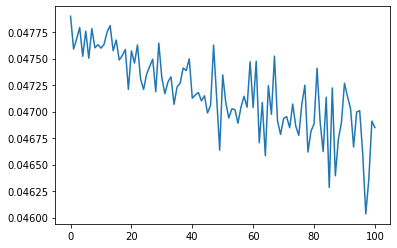

Finish training.
Finish build model.
ImgDataset test


100%|██████████| 5/5 [00:02<00:00,  2.05it/s]


Testing...
correct_imgs :  20
img_num :  100
accuracy :  0.2


In [ ]:
from matplotlib import pyplot as plt

device = 'cuda:0'

class Trainer(object):
    def __init__(self, epochs, batch_size, lr):
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = lr
        self._build_model()

        dataset = ImgDataset(method='train')
        self.root = dataset.root
        self.dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
        print(self.dataloader)

        # Load of pretrained_weight file
        # weight_PATH = '/content/gdrive/My Drive/modelweight.pth'
        # self.poseNet.load_state_dict(torch.load(weight_PATH))

        print("Training...")

    def _build_model(self):
        resnet = ResNet(base_dim=64, num_classes=20)
        self.resnet = resnet.to(device)
        self.resnet.train()

        print('Finish build model.')

    def train(self):
        date = '201205'

        loss_func = torch.nn.MSELoss()
        optimizer = torch.optim.SGD(self.resnet.parameters(), lr=self.learning_rate)

        losses = []
        
        for epoch in tqdm.tqdm(range(self.epochs + 1)):
            if epoch % 2 == 0:
                torch.save(self.resnet.state_dict(), "_".join(['/content/gdrive/My Drive/CV_Final/', date, str(epoch), 'model.pth']))

            for batch_idx, samples in enumerate(self.dataloader):
                optimizer.zero_grad()

                x_train, y_train = samples
                result_resnet = self.resnet(x_train.cuda())
                gt_result = self.y_train2gt_result(result_resnet, y_train)

                loss = loss_func(result_resnet, gt_result)
                loss.backward()
                optimizer.step()

                # Write train result
                if batch_idx % 20 == 0:
                    with open('train_result_' + date + '.txt', 'a') as f:
                        f.write('Epoch {:4d}/{} Batch {}/{}\n'.format(
                            epoch, self.epochs, batch_idx, len(self.dataloader)
                        ))
                    print('Epoch {:4d}/{} Batch {}/{}'.format(
                        epoch, self.epochs, batch_idx, len(self.dataloader)
                    ))
            
            losses.append(loss.item())
                
        plt.plot(losses)
        plt.show()

        print('Finish training.')

    def y_train2gt_result(self, _result_resnet, y_train):
        resnet_gt = torch.zeros_like(_result_resnet, device=_result_resnet.device)

        for i in range(y_train.shape[0]): # batch size (# of images)
            x = int(y_train[i])
            resnet_gt[i, x] = 1

        resnet_gt = resnet_gt.detach().cpu().numpy()
        resnet_gt = torch.FloatTensor(resnet_gt).to(device)
        return resnet_gt
    

class Tester(object):
    def __init__(self, batch_size):
        self.batch_size = batch_size
        self._build_model()

        dataset = ImgDataset(method='test')
        self.root = dataset.root
        self.dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=False)
        self.datalen = dataset.__len__()
        self.mse_all_img = []

        # load the weight
        weight_PATH = '/content/gdrive/My Drive/CV_Final/_201205_100_model.pth'
        self.resnet.load_state_dict(torch.load(weight_PATH))

        print("Testing...")

    def _build_model(self):
        resnet = ResNet(base_dim=64, num_classes=20)
        self.resnet = resnet.to(device)

        print('Finish build model.')

    def test(self):
        correct_imgs = 0
        num_imgs = 0 # number of img

        for batch_idx, samples in enumerate(self.dataloader):
            x_test, y_test = samples
            result_resnet = self.resnet(x_test.cuda()).cpu().detach().numpy()
        
            # calculate the error
            # for each img, call calc_error()
            for img_idx, result_img in enumerate(result_resnet):
                if np.argmax(result_img) == y_test[img_idx]:
                    correct_imgs += 1
                num_imgs += 1

        print('correct_imgs : ', correct_imgs)
        print('img_num : ', num_imgs)
        print('accuracy : ', correct_imgs/num_imgs)



batchSize = 50

def main():

    epochs = 100
    learningRate = 1e-1

    trainer = Trainer(epochs, batchSize, learningRate)
    trainer.train()

    tester = Tester(batchSize)
    tester.test()


if __name__ == '__main__':
    main()